In [47]:
import numpy as np
from PIL import Image
from dataclasses import dataclass

In [77]:
screen_x, screen_y = 1920, 1080 
eye_distance = 2
distance_to_origin = 2

@dataclass
class Vertex:
    xyz: np.ndarray[3]
    distance: int = 0

    @property
    def x(self): return self.xyz[0]
    @property
    def y(self): return self.xyz[1]
    @property
    def z(self): return self.xyz[2]
    def update_distance(self):
        self.distance = np.sqrt(
            self.x * self.x +
            self.y * self.y + 
            (eye_distance + distance_to_origin + self.z) *
            (eye_distance + distance_to_origin + self.z)
        )

size_at_unit_1 = 32
def draw_circle(x: int, y: int, color: float, distance: int, data: np.ndarray) -> None:
    size = int(size_at_unit_1 / distance)
    color = 0.2 * color + 0.8 * (color / size)
    for dy in range(-size, +size):
        for dx in range(-size, +size):
            r = np.sqrt(dy * dy + dx * dx)
            if r >= size:
                continue
            rasterize(x + dx, y + dy, color, data = data)

def rasterize(x: int, y: int, color: float, data: np.ndarray):
    if (x < 0 or x >= screen_x) or (y < 0 or y >= screen_y):
        return
    data[-y][x] = color

def draw_vertex(vert: Vertex, data: np.ndarray) -> tuple[int, int]:
    k = eye_distance / (eye_distance + distance_to_origin + vert.z)
    print("K: ", k)
    proj_y = vert.y * k
    proj_x = vert.x * k
    screen_proj_y = int(screen_y * proj_y + screen_y // 2)
    screen_proj_x = int(screen_x * proj_x + screen_x // 2)
    vert.update_distance()

    print("                    x   y   z")
    print("World position:    ", vert.x, vert.y, vert.z)
    print("Screen projection: ", proj_x, proj_y)
    print("Screen pixels:     ", screen_proj_x, screen_proj_y)
    print("Distance: ", vert.distance)
    
    draw_circle(screen_proj_x, screen_proj_y, distance = vert.distance, color = 255.0, data = data)
    # Image.fromarray(data).show()

data = np.zeros((screen_y, screen_x))
point1 = Vertex([0.0, 0.0, 0.0])
draw_vertex(point1, data)

K:  0.5
                    x   y   z
World position:     0.0 0.0 0.0
Screen projection:  0.0 0.0
Screen pixels:      960 540
Distance:  4.0


K:  2.0
                    x   y   z
World position:     0.0 0.0 -3.0
Screen projection:  0.0 0.0
Screen pixels:      960 540
Distance:  1.0
K:  1.9038461538461537
                    x   y   z
World position:     0.0 0.0 -2.9494949494949494
Screen projection:  0.0 0.0
Screen pixels:      960 540
Distance:  1.0505050505050506
K:  1.8165137614678897
                    x   y   z
World position:     0.0 0.0 -2.898989898989899
Screen projection:  0.0 0.0
Screen pixels:      960 540
Distance:  1.1010101010101012
K:  1.7368421052631582
                    x   y   z
World position:     0.0 0.0 -2.8484848484848486
Screen projection:  0.0 0.0
Screen pixels:      960 540
Distance:  1.1515151515151514
K:  1.6638655462184875
                    x   y   z
World position:     0.0 0.0 -2.797979797979798
Screen projection:  0.0 0.0
Screen pixels:      960 540
Distance:  1.202020202020202
K:  1.596774193548387
                    x   y   z
World position:     0.0 0.0 -2.7474747474747474
Screen projec

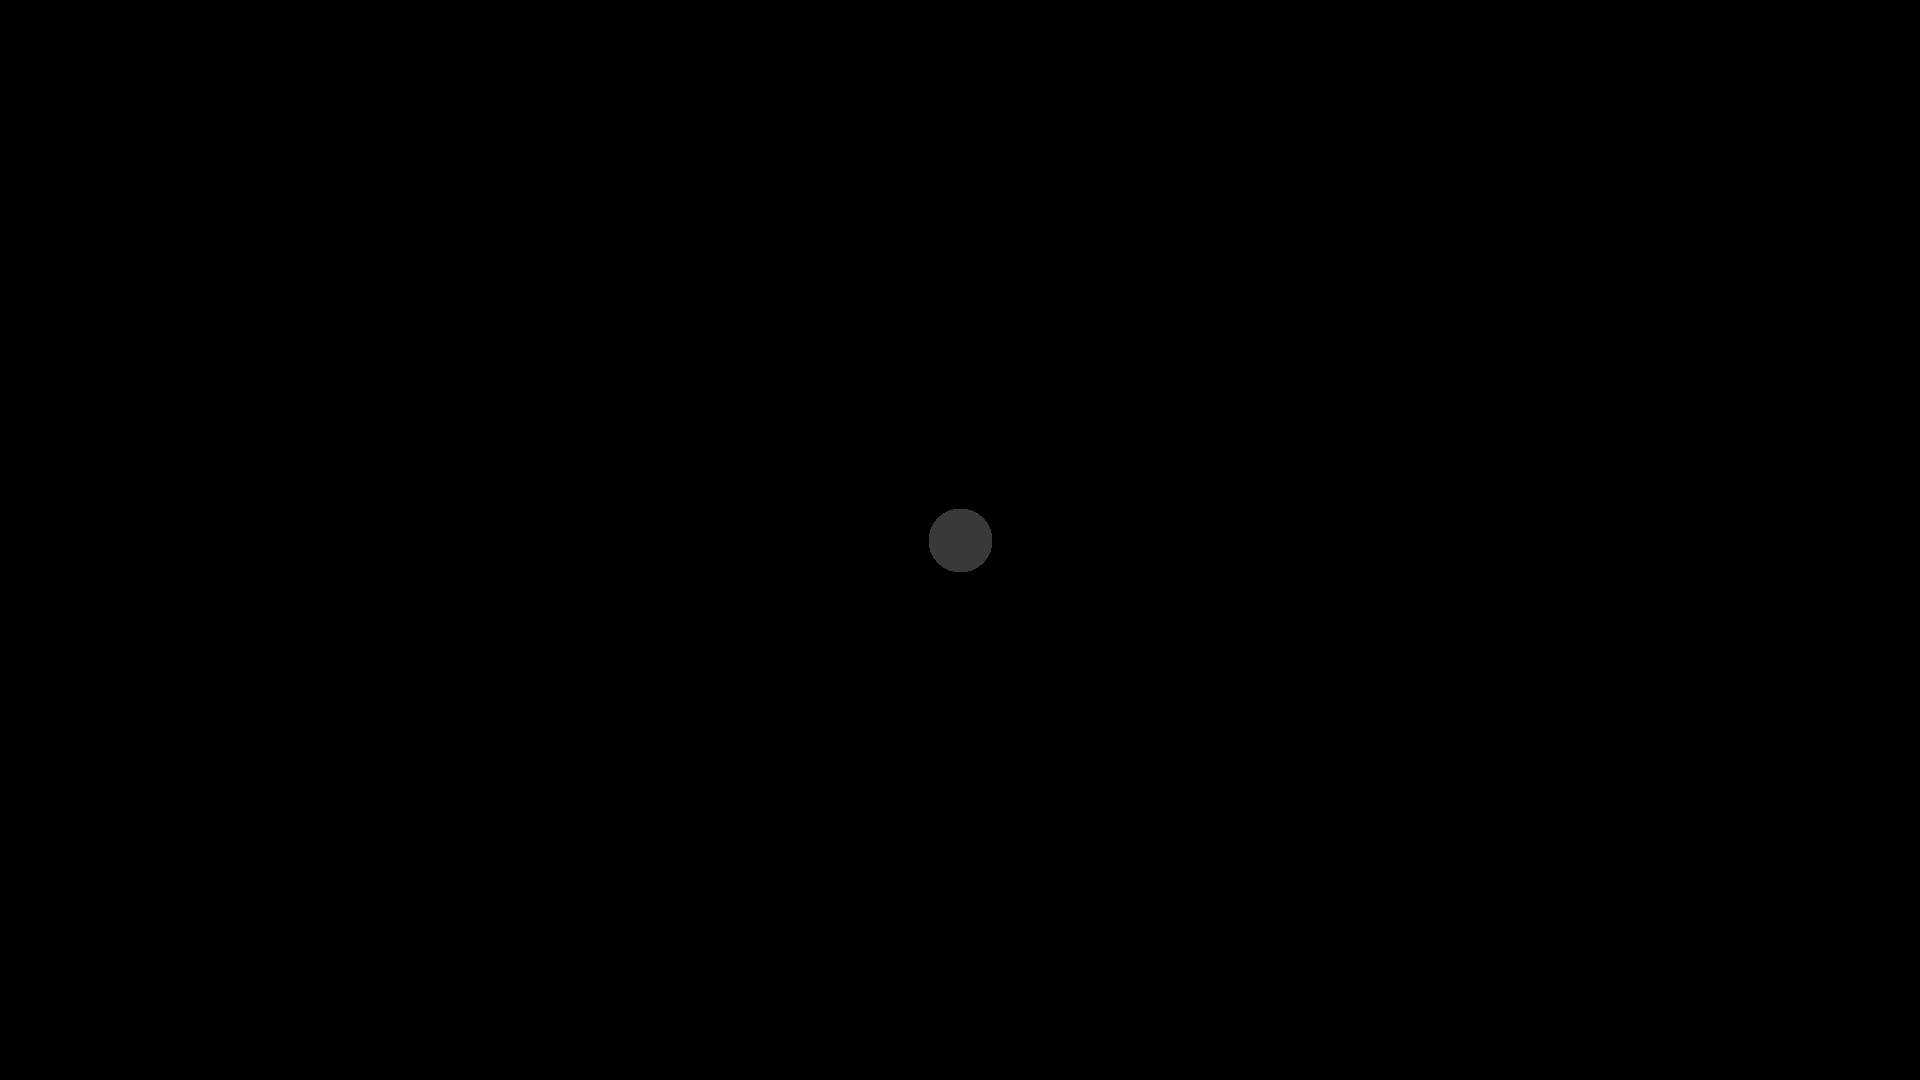

In [84]:
import imageio

frames = imageio.get_writer("point.gif", mode="I")
for t in np.linspace(0, 5, 100):
    pic = np.zeros((screen_y, screen_x))
    v = Vertex([0.0, 0.0, -3.0 + t])
    draw_vertex(v, pic)
    frames.append_data(pic)
frames.close()

from IPython.display import Image, display
display(Image(filename='point.gif'))